In [3]:
from pyiron import Project
import ase.units as units
import numpy as np
import re
from pyiron_atomistics import ase_to_pyiron
%matplotlib inline
import matplotlib.pylab as plt
from ase.io import read
plt.rcParams.update(
    {'font.size': 20, 'legend.fontsize': 14, 
     'legend.handlelength': 0.5, 'lines.markersize':10,
     'axes.linewidth':2,'lines.linewidth':2.5})
pr = Project('Ne_TP_test')


/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2025-11-03/lib/python3.12/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [199]:
# Place the 'Au_H2O_Ne_POSCAR' file in the Project directory that was created above, named 'Ne_TP_test'
ase_structure = read(pr.path + 'Au_H2O_Ne_POSCAR')

In [200]:
struct = ase_to_pyiron(ase_structure)

In [201]:
struct.plot3d()

NGLWidget()

In [203]:
#MD Test


Q0 = 0  # Initial charge, usually set to zero, except when restarting jobs.
nelect_neutral = 1312  # Number of electrons of the neutral system
ncore = 160    # Number of cores
n_steps = 500  # Number of ionic steps
pos_dipole = 0.86  # Dipole correction position, check for every cell size / system
phi_list = [-2,2]  # List of voltages (in V) to be applied 
temperature  = 400
langevin_constant = 5.0


formula = (struct.get_chemical_formula())
# Find all element symbols: uppercase letter optionally followed by lowercase letters
elements = re.findall(r'[A-Z][a-z]?', formula)
# Make a set to keep only distinct elements
n_elements = len(set(elements))
print('Number of chemical elements is ',n_elements)

phi_list=[-2,2]
for phi in phi_list:
    job = pr.create_job(pr.job_type.Vasp, f'Au_H2O_Ne_phi'+str(np.round(phi,3))+ f'_n_steps{n_steps}_test1')


    #Flags central to the setup
    job.structure = struct
    job.set_kpoints([1, 1, 1])
    job.executable.version = 'edge_v3_gamma_mpi'
    job.input.incar['PLUGINS/LOCAL_POTENTIAL'] = 'T' # Enables modification of potential through python plugin
    job.input.incar['PLUGINS/OCCUPANCIES'] = 'T' # Enables modification of occupancies through python plugin
    job.calc_md()
    job.input.incar["TEBEG"]= temperature 
    job.input.incar["MDALGO"] = 3 # Langevin thermostat


    thermo_constant = []
    for i in range(n_elements):
        thermo_constant.append(str(langevin_constant))

    job.input.incar["LANGEVIN_GAMMA"] =' '.join(thermo_constant)  # Thermostat time constant
    job.input.incar["NSW"] = n_steps
    job.input.incar["NELECT"] = nelect_neutral + Q0


    # Dipole correction
    job.input.incar["IDIPOL"] = 3
    center = [0., 0., np.max(struct.get_scaled_positions()[:, 2]) / 2.]
    job.input.incar["DIPOL"] = " ".join([str(c) for c in center])
    job.input.incar["LDIPOL"] = True
    
    #Other flags, check for specific setup
    job.input.incar["LWAVE"] = True
    job.input.incar['LCHARG'] = True
    job.input.incar['ENCUT'] = 500
    job.input.incar["LVHAR"] = True
    job.set_occupancy_smearing(smearing="fermi", width=0.1)
    job.input.incar["EDIFF"] = 1e-4
    job.input.incar["LREAL"] = "Auto"
    job.input.incar["PREC"] = 'NORMAL'
    job.input.incar["IWAVPR"] = 1
    job.input.incar["LORBIT"]  =11
    job.input.incar["POTIM"]  = 0.5
    job.input.incar["AMIN"]= 0.01
    job.input.incar["NCORE"] = 40
    job.input.incar["IVDW"]=12
    job.input.incar["NELM"]=200 
    job.input.incar["ISIF"]=2
    job._compress_by_default = False
    job.server.queue = 'cmti'
    
    job.server.cores = ncore

    plugin_path = pr.path.replace(pr.name+'/','') +"vasp_plugin_TP_Ne_v3.py"

    if np.any(pr.job_table(full_table=True)['job']==job.name):
        print('Job with this name already exists!!! Change job name')
    else:
        job.save()
        job.project_hdf5.create_working_directory()
        job.write_input()  ### Modify VASP Plugin

        file_name = job.working_directory+'/POTCAR'
        unwanted_strings = ['   POMASS =   20.180; ZVAL   =    8.000    mass and valenz\n']
       
        n_Ne = len(struct.select_index('Ne'))
    
        # Modifies initial charge on Ne CCE 
        new_strings = [f'   POMASS =   20.180; ZVAL   =    {(8+np.round(Q0/n_Ne,8)):.7f}    mass and valenz\n']  ## Important to have several digits, otherwise VASP will give error
        #Read the file
        with open(file_name, "r") as file:
            lines = file.readlines()
        for i,j  in enumerate(unwanted_strings):
            index = lines.index(unwanted_strings[i])
            lines[index] = new_strings[i]
        with open(file_name, "w") as file:
            file.writelines(lines)
    
        # Read the file
        with open(plugin_path, "r") as file:
            lines = file.readlines()
        
        ax, ay, az = np.diag(struct.cell)
        d_electrode = max(struct[struct.select_index('Ne')].positions[:,2]) - max(struct[struct.select_index('Au')].positions[:,2])

        lines[12] = f'phi0 = {phi } \n' 
        lines[15] = f'Q0 = {Q0 } \n' 
        lines[19] = f'nelect_neutral =  {nelect_neutral} \n' 
        lines[20] = f'grid_roll_frac ={0.1}  \n' # Might vary, depends on the cell size. You can also try 0.2
        lines[21] = f'grid_position_frac ={pos_dipole}  \n'
        lines[24] = f'ax, ay, az = {ax, ay, az} \n' 
        lines[26] = f'd_electrode = {d_electrode} \n' 
        lines[29] = f'temperature = {temperature} \n' 
        lines[32] = f'''i_Ne = {elements.index('Ne')} \n'''
        lines[33] = f'''n_elements = {n_elements}  \n'''
        lines[34] = f'''n_Ne = {len(struct.select_index('Ne'))}  \n'''
        
        file_name = job.working_directory+'/vasp_plugin.py'
        with open(file_name, "w") as file:
            file.writelines(lines)
        
        file_name = job.working_directory+'/INCAR'
        unwanted_strings = ['NBLOCK=1\n']  # Needs to be removed because pyiron doesn't parse it
        new_strings = ['\n']
        # Read the file
        with open(file_name, "r") as file:
            lines = file.readlines()
        for i,j  in enumerate(unwanted_strings):
            index = lines.index(unwanted_strings[i])
            lines[index] = new_strings[i]
        
        unwanted_string='NELECT'
        
        # This is to make sure NELECT and the Ne ZVAL cancel out exactly
        Q0 = 16*(np.float64(f'{(8+np.round(Q0/n_Ne,8)):.7f}') - 8)     
        for i,j  in enumerate(lines):
            if unwanted_string in j:
                lines[i]=f'NELECT={nelect_neutral  + Q0}\n'
        
        with open(file_name, "w") as file:
            file.writelines(lines)
    
        job.run(delete_existing_job=False)



Number of chemical elements is  4
Job with this name already exists!!! Change job name


2025-11-05 11:35:59,044 - pyiron_log - WARNING - Could not access indices, returning None!
2025-11-05 11:35:59,059 - pyiron_log - WARNING - Could not access indices, returning None!


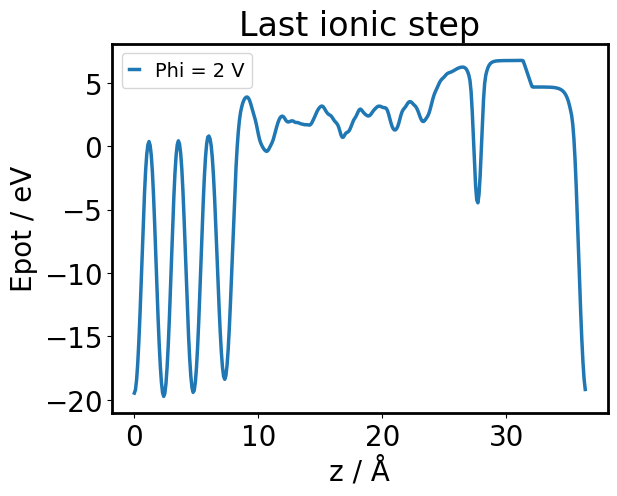

In [127]:
job = pr.load('Au_H2O_Ne_phi2_n_steps500_test1')
struct = job.get_structure()
job.decompress()
pot_z = np.loadtxt(job.working_directory+'/el_pot_z.dat')
nz = pot_z.shape[0]//n_steps

pot_z = pot_z.reshape([n_steps, nz])  # Last step only
plt.plot(np.linspace(0,struct.cell[2][2],nz),pot_z[-1],label = f'Phi = {str(np.round(phi,3))} V')


plt.title('Last ionic step')
plt.xlabel('z / Å')
plt.ylabel('Epot / eV')
plt.legend()

2025-11-05 11:35:44,253 - pyiron_log - WARNING - Could not access indices, returning None!
2025-11-05 11:35:44,282 - pyiron_log - WARNING - Could not access indices, returning None!


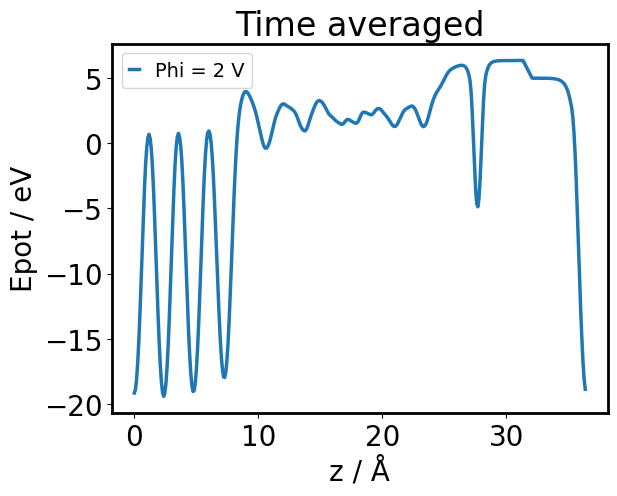

In [126]:
job = pr.load('Au_H2O_Ne_phi2_n_steps500_test1')
struct = job.get_structure()
job.decompress()
pot_z = np.loadtxt(job.working_directory+'/el_pot_z.dat')
nz = pot_z.shape[0]//n_steps

pot_z = pot_z.reshape([n_steps, nz])  # Last step only
plt.plot(np.linspace(0,struct.cell[2][2],nz),np.mean(pot_z,axis=0),label = f'Phi = {str(np.round(phi,3))} V')

plt.title('Time averaged')
plt.xlabel('z / Å')
plt.ylabel('Epot / eV')
plt.legend()

### Potential sign convention
#### An applied bias $\Phi_{0}$ that is positive against the potential of zero charge (PZC) will lead to negative electronic charges in the working electrode. Since the electrode charge $n_{electrode}$ is in $e^-$, that results in working electrode that is electron deficient.
#### Similarly, an applied bias $\Phi_{0}$ that negative against the potential of zero charge (PZC) will lead to a working electrode/ surface that has excess electrons.

#### Example: if the PZC of my system is -0.5 V , then applying a 1.0 V potential will result in a potential that is 1.5 V vs PZC and applying a -1.0 V potential will lead to a potential of -0.5 vs PZC. The 1.5 V vs PZC potential will lead to a surface that is electron deficient, while the -0.5 V vs PZC potential will have an excess of electron at that surface, in principle.

##### Be careful to not apply too large of a potential which can lead to dielectric breakthrough.

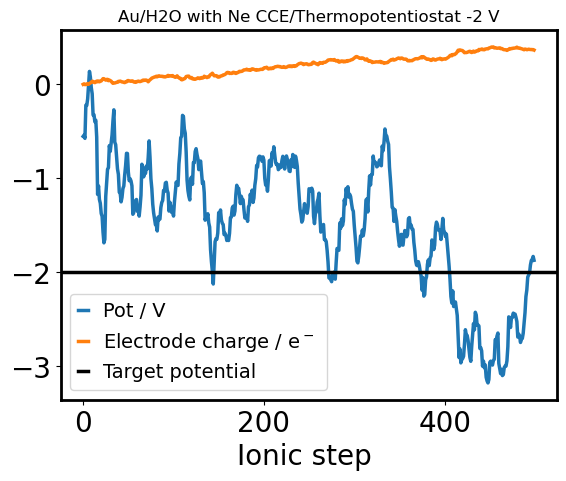

In [149]:

job = pr.load('Au_H2O_Ne_phim2_n_steps500_test1')
charge_list = np.loadtxt(job.working_directory+'/Q.dat')
pot_list = np.loadtxt(job.working_directory+'/phi.dat')

plt.plot(pot_list,label='Pot / V')
plt.plot(charge_list,label='Electrode charge / e$^-$ ')
plt.axhline(-2,color = 'black',label='Target potential')
plt.xlabel('Ionic step ')

plt.title('Au/H2O with Ne CCE/Thermopotentiostat -2 V',size=12)
plt.legend()


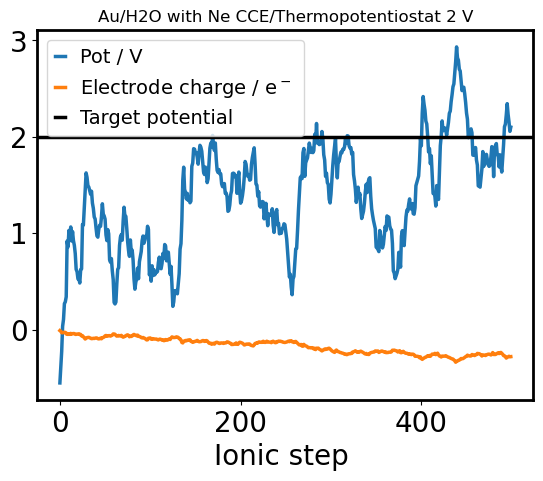

In [150]:

job = pr.load('Au_H2O_Ne_phi2_n_steps500_test1')
charge_list = np.loadtxt(job.working_directory+'/Q.dat')
pot_list = np.loadtxt(job.working_directory+'/phi.dat')

plt.plot(pot_list,label='Pot / V')
plt.plot(charge_list,label='Electrode charge / e$^-$ ')
plt.axhline(2,color = 'black',label='Target potential')
plt.xlabel('Ionic step ')

plt.title('Au/H2O with Ne CCE/Thermopotentiostat 2 V',size=12)
plt.legend()


### Restarting jobs
#### Below we have a function that is able to restart MD runs so that one have a continuous trajectory with the thermopotentiostat. Sucessive runs rely on the electrode charge of the penultimate step of the previous run, as well as the CHGCAR file, and of course the other usual files (KPOINTS,INCAR, etc).
#### This function takes in a list containing the names of jobs that should be restarted. These jobs should be written in the format '____test', such as 
#### job_list = ['Au_H2O_Ne_phim2_n_steps500_test','Au_H2O_Ne_phi2_n_steps500_test']
#### We don't have to specify if it is test1, test 7 and so on, since the function will search in the job table for the highest value of '___test(n)' and restart that job if is finished. For example, if we have run 'water_metal_n5000_test1','water_metal_n5000_test2','water_metal_n5000_test3', then the last job 'water_metal_n5000_test3' will be taken and restarted


### Pay attention!
#### Check in the last lines of the restart function, that the number of cores, VASP version etc is correct



In [159]:

def restart_jobs_Ne_TP(names_job,nelect_neutral):

    jobs_restart = []
    for name in names_job:
        jobs_restart.append(name)
    
    for job_name in jobs_restart:
        id_list=[]
        pr.job_table(full_table=True)
    
        for idx, job in pr.job_table(full_table=True).iterrows():
             if ((job_name in job.job)):  
                id_list.append(job.id)
                print(job.job)
    
        job = pr.load(max(id_list))
        if job.status=='finished':
            print(id_list)
            
            if job_name in job.name:
                #MD restart test
                print('Restarting job')
                name_old_job=job.name
                job.decompress()
                
                i = int(name_old_job[name_old_job.find('test')+len('test')-len(name_old_job):])
                
                name_new_job=name_old_job.replace(f'test{i}',f'test{i+1}')
                
                
                job_new = pr.create_job(pr.job_type.Vasp, name_new_job)
                struct=job.get_structure(iteration_step=-1)
                
                #struct=job.structure
                job_new.structure = struct

                
                job_new.executable.version = 'edge_v3_gamma_mpi'
                print('This was the old one ',name_old_job,'This is the new one ',name_new_job)
                
                plugin_path = job.working_directory +"/vasp_plugin.py"
                job_new.save()
                job_new.project_hdf5.create_working_directory()
                job_new.write_input()### Modify VASP Plugin
                    
                file_name = job.working_directory+'/INCAR'
                with open(file_name, "r") as file:
                    lines = file.readlines()
                file_name = job_new.working_directory+'/INCAR'
                with open(file_name, "w") as file:
                    file.writelines(lines)
                    
                file_name = job.working_directory+'/KPOINTS'
                with open(file_name, "r") as file:
                    lines = file.readlines()
                file_name = job_new.working_directory+'/KPOINTS'
                with open(file_name, "w") as file:
                    file.writelines(lines)

                file_name = job.working_directory+'/CHGCAR'
                with open(file_name, "r") as file:
                    lines = file.readlines()
                file_name = job_new.working_directory+'/CHGCAR'
                with open(file_name, "w") as file:
                    file.writelines(lines)
                
                file_name = job.working_directory+'/CONTCAR'
                with open(file_name, "r") as file:
                    lines = file.readlines()
                file_name = job_new.working_directory+'/POSCAR'
                with open(file_name, "w") as file:
                    file.writelines(lines)

                            
                q_path = job.working_directory + "/Q.dat"
                with open(q_path, "r") as file:
                    lines = file.readlines()
                Q_final = lines[-2]
                
                # Read the file
                with open(plugin_path, "r") as file:
                    lines = file.readlines()
                

                unwanted_string='Q0 ='
                for i,j  in enumerate(lines):
                    if unwanted_string in j:
                        lines[i]=f'Q0 = {Q_final} \n'
                
                file_name = job_new.working_directory+'/vasp_plugin.py'
                
                with open(file_name, "w") as file:
                    file.writelines(lines)


                file_name = job.working_directory+'/POTCAR'
                
                unwanted_strings = ['POMASS =   20.180;']
                
                n_Ne = len(struct.select_index('Ne'))
                Q_final = np.float64(Q_final)
                new_strings = [f'   POMASS =   20.180; ZVAL   =    {(8+np.round(Q_final/n_Ne,8)):.7f}    mass and valenz\n']  ## Important to have several digits, otherwise VASP will give error
                # #Read the file
                with open(file_name, "r") as file:
                    lines = file.readlines()
                for i, unwanted in enumerate(unwanted_strings):
                    for idx, line in enumerate(lines):
                        if unwanted in line:
                            lines[idx] = new_strings[i]
                            break   # stop after first match for this unwanted string
                file_name = job_new.working_directory+'/POTCAR'                
                with open(file_name, "w") as file:
                    file.writelines(lines)

                
                file_name = job.working_directory+'/INCAR'
                with open(file_name, "r") as file:
                    lines = file.readlines()
                unwanted_string='NELECT'


                Q_final = n_Ne*(np.float64(f'{(8+np.round(Q_final/n_Ne,8)):.7f}') - 8) # This is to make sure the simulation is exaclty neutral                
                for i,j  in enumerate(lines):
                    if unwanted_string in j:
                        lines[i]=f'NELECT={nelect_neutral  + Q_final }\n'

                file_name = job_new.working_directory+'/INCAR'
                if not any('ICHARG' in s for s in lines):
                    lines.append('ICHARG=1\n')
                with open(file_name, "w") as file:
                    file.writelines(lines)

                #Modify if necessary    
                job_new.server.queue = 'cmti'
                job_new.executable.version = 'edge_v3_gamma_mpi'
                job_new.server.cores = 160
                job_new._compress_by_default = False
                job_new.run(delete_existing_job=False)
                

        else:
            print('Job not done')

In [161]:
job_list = ['Au_H2O_Ne_phim2_n_steps500_test','Au_H2O_Ne_phi2_n_steps500_test']
nelect_neutral = 1312
restart_jobs_Ne_TP(job_list,nelect_neutral)

Au_H2O_Ne_phim2_n_steps500_test1


/tmp/ipykernel_30088/3689910704.py:32: DeprecationWarning: pyiron_atomistics.atomistics.structure.has_structure.HasStructure.get_structure(iteration_step=-1) is deprecated.
  struct=job.get_structure(iteration_step=-1)
2025-11-05 13:46:37,350 - pyiron_log - WARNING - Could not access indices, returning None!
2025-11-05 13:46:37,366 - pyiron_log - WARNING - Could not access indices, returning None!


[30430759]
Restarting job
This was the old one  Au_H2O_Ne_phim2_n_steps500_test1 This is the new one  Au_H2O_Ne_phim2_n_steps500_test2
The job Au_H2O_Ne_phim2_n_steps500_test2 was saved and received the ID: 30433641
Queue system id:  18659261
Au_H2O_Ne_phi2_n_steps500_test1


/tmp/ipykernel_30088/3689910704.py:32: DeprecationWarning: pyiron_atomistics.atomistics.structure.has_structure.HasStructure.get_structure(iteration_step=-1) is deprecated.
  struct=job.get_structure(iteration_step=-1)
2025-11-05 13:46:38,319 - pyiron_log - WARNING - Could not access indices, returning None!
2025-11-05 13:46:38,336 - pyiron_log - WARNING - Could not access indices, returning None!


[30430760]
Restarting job
This was the old one  Au_H2O_Ne_phi2_n_steps500_test1 This is the new one  Au_H2O_Ne_phi2_n_steps500_test2
The job Au_H2O_Ne_phi2_n_steps500_test2 was saved and received the ID: 30433642
Queue system id:  18659262


### Once enough sufficient continuous trajectories are run, different analyses can be conducted.

